In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from collections import Counter
from wordcloud import WordCloud

In [2]:
df = pd.read_csv(r'/mnt/d/BusinessSuiteData/Mercari/train.tsv', sep='\t')

In [3]:
df

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


<center><h3>EDA

<center>Univariate Checks

In [4]:
### train_id

# We can work withouth train_id

df['train_id'].nunique() == df.shape[0]

True

In [5]:
### item_condition_id

pd.concat([df['item_condition_id'].value_counts(), 
           df['item_condition_id'].value_counts(normalize=True).mul(100).to_frame(name='%')], 
          axis= 1)

,item_condition_id,%
1,640549,43.206332
3,432161,29.150138
2,375479,25.326822
4,31962,2.155902
5,2384,0.160806


In [6]:
### Category Name

df['category_name'].nunique()

df['category_name'].value_counts(dropna=False)

1287

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Dolls and Miniatures/Primitive               1
Handmade/Pets/Tag                                     1
Handmade/Patterns/Accessories                         1
Home/Kids' Home Store/Nursery Furniture               1
Handmade/Pets/Blanket                                 1
Name: category_name, Length: 1288, dtype: int64

In [7]:
# How many == 1 ?

(df['category_name'].value_counts() == 1).value_counts()

False    1203
True       84
Name: category_name, dtype: int64

In [8]:
### brand_name

df['brand_name'].nunique()

df['brand_name'].isna().value_counts() # 632682 missing brands

4809

False    849853
True     632682
Name: brand_name, dtype: int64

In [9]:
### price

with pd.option_context('display.float_format', 
                       lambda x: f'{x:,.3f}'):

    df['price'].describe().to_frame()
    
# NB : Q3 vs Max, right skewed

,price
count,"1,482,535.000"
mean,26.738
std,38.586
min,0.000
25%,10.000
50%,17.000
75%,29.000
max,"2,009.000"


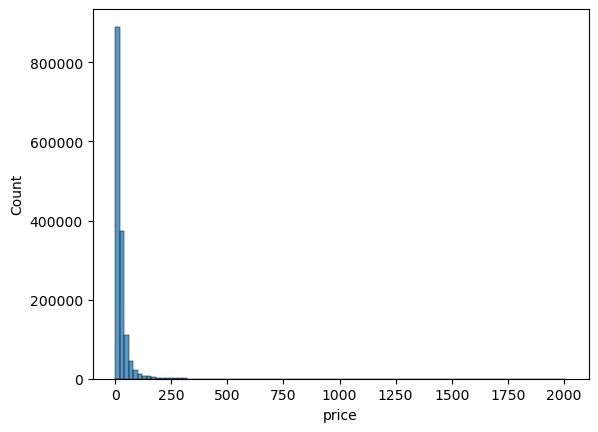

In [10]:
# Outliers check 

sns.histplot(data=df, 
             x = 'price', 
             bins = 100)
plt.show();

In [11]:
print('Price < 250 :')

pd.concat([(df['price'] > 250).value_counts(), 
           (df['price'] > 250).value_counts(normalize=True).to_frame(name='%')], axis = 1)

Price < 250 :


,price,%
False,1476408,0.995867
True,6127,0.004133


In [12]:
### shipping

df['shipping'].value_counts(dropna=False)

0    819435
1    663100
Name: shipping, dtype: int64

In [13]:
### item_description

df['item_description'].nunique()

1281426

In [14]:
### Missing values checks

category_name Focus

In [15]:
# Hierarchy ? 

df['category_name']

# If fisrt category is gender => clothing & accessories
# Else object ?

0                                          Men/Tops/T-shirts
1          Electronics/Computers & Tablets/Components & P...
2                                Women/Tops & Blouses/Blouse
3                         Home/Home Décor/Home Décor Accents
4                                    Women/Jewelry/Necklaces
                                 ...                        
1482530                               Women/Dresses/Mid-Calf
1482531                             Kids/Girls 2T-5T/Dresses
1482532       Sports & Outdoors/Exercise/Fitness accessories
1482533                   Home/Home Décor/Home Décor Accents
1482534                    Women/Women's Accessories/Wallets
Name: category_name, Length: 1482535, dtype: object

In [16]:
categories_list_df = df['category_name'].apply(lambda x : str(x).split('/'))

categories_list_df

0                                      [Men, Tops, T-shirts]
1          [Electronics, Computers & Tablets, Components ...
2                            [Women, Tops & Blouses, Blouse]
3                     [Home, Home Décor, Home Décor Accents]
4                                [Women, Jewelry, Necklaces]
                                 ...                        
1482530                           [Women, Dresses, Mid-Calf]
1482531                         [Kids, Girls 2T-5T, Dresses]
1482532    [Sports & Outdoors, Exercise, Fitness accessor...
1482533               [Home, Home Décor, Home Décor Accents]
1482534                [Women, Women's Accessories, Wallets]
Name: category_name, Length: 1482535, dtype: object

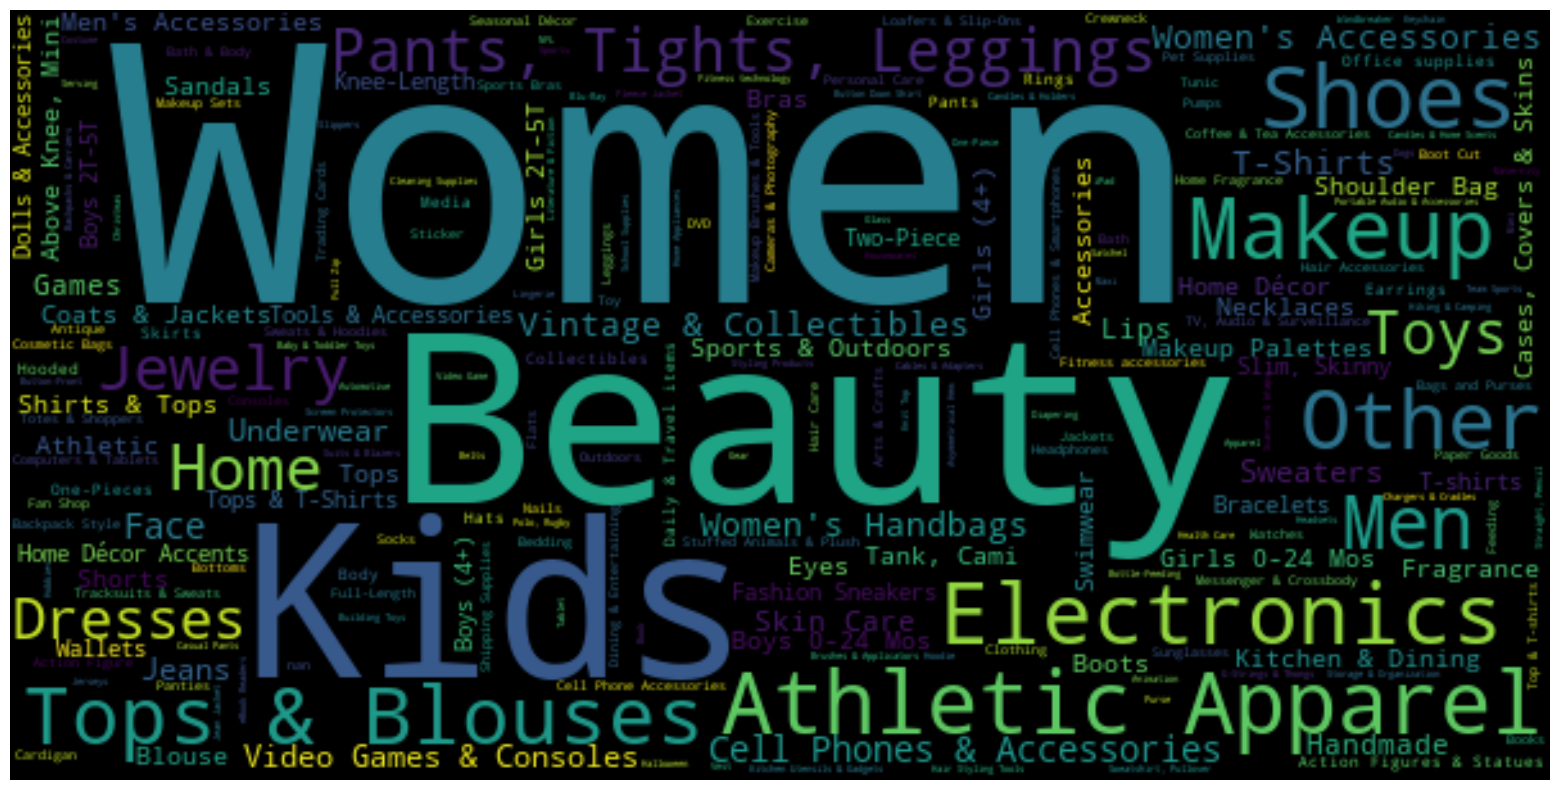

In [17]:
# Wordcloud of categories

list_of_lists_of_categories = categories_list_df.values

list_of_merged_categories = []
for el_list in list_of_lists_of_categories:
    for element in el_list:
        list_of_merged_categories.append(element)

wordcloud = WordCloud(random_state = 34,
        normalize_plurals = False,
        width = 600, height= 300,
        max_words = None,
        stopwords = [])

wordcloud.generate_from_frequencies(frequencies=Counter(list_of_merged_categories))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show();

In [18]:
categories_list_df.apply(lambda x: len(x)).value_counts()

3    1471819
1       6327
5       3059
4       1330
Name: category_name, dtype: int64

Ideas & Questions

In [19]:
df['name'].nunique() # Duplicates ? => NO

df.duplicated().value_counts()

1225273

False    1482535
dtype: int64

In [20]:
# Feature Engineering : columns with bool : 'is generic name ?'

df['name'].nunique()

# + 

df['item_description'].nunique() # Same description

1225273

1281426

In [21]:
# Feature Engineering : is it interesting to one hot encode ?

df['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

In [22]:
# Cleaning to be done, semantic statistic ?

(df['category_name'].value_counts() == 1).value_counts()

False    1203
True       84
Name: category_name, dtype: int64

In [23]:
# Outliers Price

print('Price < 250 :')

pd.concat([(df['price'] > 250).value_counts(), 
           (df['price'] > 250).value_counts(normalize=True).to_frame(name='%')], axis = 1)

Price < 250 :


,price,%
False,1476408,0.995867
True,6127,0.004133


In [24]:
# out of category_name, one can have : gender, object type, age (kids or men women ?), etc

df['category_name'].head()

# Go explore len 1, 4 ,5 

categories_list_df.apply(lambda x: len(x)).value_counts()

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
Name: category_name, dtype: object

3    1471819
1       6327
5       3059
4       1330
Name: category_name, dtype: int64

In [25]:
# Name to brand name imputations ?

<center>First Cleaning

In [26]:
df_cl_1 = df.copy()

In [27]:
def imputate_category_name(x_list, index_list):
    try :
        return x_list[index_list]
    except: 
        return np.nan

df_cl_1['category_name_0'] = categories_list_df.apply(lambda x : imputate_category_name(x, 0))
df_cl_1['category_name_1'] = categories_list_df.apply(lambda x : imputate_category_name(x, 1))
df_cl_1['category_name_2'] = categories_list_df.apply(lambda x : imputate_category_name(x, 2))

In [28]:
df_cl_1

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_0,category_name_1,category_name_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces
...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",Women,Dresses,Mid-Calf
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape.",Sports & Outdoors,Exercise,Fitness accessories
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...,Home,Home Décor,Home Décor Accents


In [47]:
# Nones impuatations for categorical values

df_cl_1['brand_name'] = df_cl_1['brand_name'].fillna(value ='None')
df_cl_1['category_name_0'] = df_cl_1['category_name_0'].fillna(value ='None')
df_cl_1['category_name_0'] = df_cl_1['category_name_0'].apply(lambda x : 'None' if x == 'nan' else x)
df_cl_1['category_name_1'] = df_cl_1['category_name_1'].fillna(value ='None')
df_cl_1['category_name_2'] = df_cl_1['category_name_2'].fillna(value ='None')
df_cl_1['item_description'] = df_cl_1['item_description'].fillna(value ='None')

In [48]:
df_cl_1['item_description'].isna().value_counts()

False    1482535
Name: item_description, dtype: int64

In [51]:
df_cl_1['category_name_0'].nunique()
df_cl_1['category_name_0'].unique()
df_cl_1['category_name_0'].isna().value_counts()

11

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'None',
       'Handmade'], dtype=object)

False    1482535
Name: category_name_0, dtype: int64

Ideas cl 1

In [57]:
# Imputate by the activity of brand ?

df_cl_1[df_cl_1['category_name_1'] == 'None'].head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_0,category_name_1,category_name_2
122,122,Bundle,3,NaN,None,59.0,0,Sizes and info of clothes can be found on thei...,None,None,None
155,155,3 Nora Roberts Books,3,NaN,None,10.0,1,For aferg16.,None,None,None
258,258,ACER Laptop,5,NaN,None,14.0,0,"Powers on, no screen display, no external dama...",None,None,None


In [58]:
# Truncate brand by range ?
# Name has infos such as the size eg train id 0
df_cl_1[df_cl_1['train_id'] == 0]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_0,category_name_1,category_name_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,None,10.0,1,No description yet,Men,Tops,T-shirts


Exports

# Exports df

df_cl_1.to_csv(r'/mnt/d/BusinessSuiteData/Mercari/clean_data/df_cl_1_{}.csv'\
                .format(datetime.now().strftime("%y-%m-%d")), index=False)